# Investment Fund Clustering and Recommender System

This notebook implements a clustering-based recommendation engine for investment funds. It groups funds with similar characteristics using unsupervised learning techniques, and suggests alternative funds when a user dislikes a given fund for specific reasons (e.g., volatility, geographical exposure).

The project combines:

- Preprocessing of structured financial fund data.
- Dimensionality reduction using UMAP.
- Clustering with DBSCAN.
- A rule-based substitute recommender.

## Dataset Overview

The dataset contains information for each fund, including:

- `isin`: Unique fund identifier.
- `performance_60d`: 60-day cumulative return.
- `volatility_60d`: 60-day volatility.
- `asset`: Risk level (0 to 7).
- `asset_type`, `asset_class`, `family`, `subcategory`: Type and family of asset.
- `class_code`: Fund class (identified by a letter).
- `clean_share`: Whether the fund has retrocession commission.
- `currency`: Trading currency.
- `geo_area`: Main geographical area (1: America, 2: Europe, 3: Asia, 4: Global).
- `geo_zone`, `nested_family`, `nested_cat`: More granular geo information.
- `inception_at`: Fund launch date.
- `income`: Whether the fund distributes dividends.
- `management_fee`: Management fee (%).
- `ongoing_charges`: Total cost as per the KIID.

## Data Loading and Preprocessing

We use a custom function to load and clean the data from three files:

- Daily NAV time series for each fund.
- A CSV file with MSCI index returns.
- A master file with fund metadata (e.g., region, asset class, fees).

The preprocessing function returns two DataFrames:
- `maestro`: structured metadata per fund.
- `df_fondos`: time series of NAVs per fund.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys

sys.path.append('/content/drive/MyDrive/MIAX/GITHUB/01_Machine_learning')

from utils import preprocess_dataset

NAVS_PATH = "/content/drive/MyDrive/MIAX/MODULO_4/Machine learning/Enunciado práctica machine learning/navs (3).pickle"
MSCI_PATH = "/content/drive/MyDrive/MIAX/GITHUB/01_Machine_learning/MSCI (2).csv"
MAESTRO_PATH = "/content/drive/MyDrive/MIAX/GITHUB/01_Machine_learning/maestro (2).csv"

maestro, df_fondos = preprocess_dataset(NAVS_PATH, MSCI_PATH, MAESTRO_PATH)

## Filtering Valid Funds and Ensuring NAV Data Integrity

We first filter the dataset to retain only the funds that:

1. Have available NAV (Net Asset Value) data.
2. Are listed in the metadata (`maestro`) file.
3. Have NAV data available for at least the last 60 trading days.

This ensures that the universe of funds used for analysis is complete and clean.

We also apply forward and backward filling (`ffill` and `bfill`) to ensure all selected funds have continuous NAV values in the last 60 days.

In [6]:
allfunds_ids = df_fondos.columns.tolist()
print(f"Total funds with NAVs: {len(allfunds_ids)}")
maestro = maestro[maestro['allfunds_id'].isin(allfunds_ids)]

last_60_days = df_fondos.tail(60)
invalid_columns = last_60_days.columns[last_60_days.isna().all()].tolist()
print(f"Funds with no NAV data in the last 60 days: {len(invalid_columns)}")
fondos = df_fondos.drop(columns=invalid_columns)

allfunds_ids = fondos.columns.tolist()
maestro = maestro[maestro['allfunds_id'].isin(allfunds_ids)]

fondos = fondos.ffill()
fondos = fondos.bfill()

Total funds with NAVs: 20191
Funds with no NAV data in the last 60 days: 662


## Calculating 60-Day Performance and Volatility

For each fund, we compute two key metrics over the last 60 business days:

- **Cumulative Return**: Measures the overall performance from the start to the end of the 60-day period.
- **Volatility**: Standard deviation of daily returns, used as a proxy for risk.

Funds with insufficient data (less than two observations) are excluded. The results are merged back into the `maestro` dataset for further use.

In [8]:
import numpy as np
import pandas as pd

def rentabilidad_acumulada(series):
    series = series.dropna()
    if len(series) < 2:
        return np.nan
    return (series.iloc[-1] / series.iloc[0]) - 1

def volatilidad(series):
    retornos_diarios = series.pct_change().dropna()
    return retornos_diarios.std()

resultados = []
for columna in fondos.columns:
    ultimos_60_dias = fondos[columna].tail(60)

    rentabilidad = rentabilidad_acumulada(ultimos_60_dias)
    vol = volatilidad(ultimos_60_dias)

    resultados.append({
        'fondo': columna,
        'rentabilidad_acumulada': rentabilidad,
        'volatilidad': vol
    })

df_resultados = pd.DataFrame(resultados).dropna()
print(df_resultados.head())

filtros_fondos = df_resultados['fondo']
maestro_filtrado = maestro[maestro['allfunds_id'].isin(filtros_fondos)]

df_resultados.rename(columns={'fondo': 'allfunds_id'}, inplace=True)
maestro_filtrado = maestro_filtrado.merge(df_resultados, on='allfunds_id', how='left')

    fondo  rentabilidad_acumulada  volatilidad
0  206399                0.012174     0.005201
1   27584                0.015899     0.005193
2   12993                0.004187     0.005288
3    8123                0.013691     0.005193
4   11125                0.001690     0.005282


## Feature Engineering for Clustering

We now prepare the metadata for clustering. The key steps are:

1. Select relevant features for fund comparison.
2. Convert boolean columns to numeric (0/1).
3. Normalize numerical columns using MinMax scaling.
4. One-hot encode categorical variables.
5. Concatenate all processed features into a final matrix for clustering.

This step ensures that all variables are on a comparable scale and in a machine-readable format.

In [9]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

selected_features = [
    'allfunds_id', 'asset', 'asset_type', 'clean_share', 'currency',
    'geo_area', 'income', 'management_fee', 'ongoing_charges',
    'family', 'rentabilidad_acumulada', 'volatilidad'
]

df_features = maestro_filtrado[selected_features].copy()

df_features['income'] = df_features['income'].astype(int)
df_features['clean_share'] = df_features['clean_share'].astype(int)

df_features.set_index('allfunds_id', inplace=True)

categorical_cols = ['asset', 'asset_type', 'currency', 'geo_area', 'family']
numeric_cols = ['management_fee', 'ongoing_charges', 'rentabilidad_acumulada', 'volatilidad']
boolean_cols = ['income', 'clean_share']

scaler = MinMaxScaler()
df_features[numeric_cols] = scaler.fit_transform(df_features[numeric_cols])

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = encoder.fit_transform(df_features[categorical_cols])
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))

df_features_processed = pd.concat([
    df_features[numeric_cols].reset_index(drop=True),
    df_features[boolean_cols].reset_index(drop=True),
    encoded_cats_df.reset_index(drop=True)
], axis=1)

df_features_processed.index = df_features.index

## Dimensionality Reduction and Clustering

We now apply UMAP to reduce the high-dimensional feature space to 2 dimensions. This allows us to visualize the fund universe and apply density-based clustering.

- **UMAP** captures the global and local structure of the data.
- **DBSCAN** (Density-Based Spatial Clustering) is used to group similar funds.
- Clusters with fewer than 30 members are discarded to avoid noise.

In [10]:
import umap
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

umap_reducer = umap.UMAP(n_neighbors=30, min_dist=0.05, random_state=42)
umap_embedding = umap_reducer.fit_transform(df_features_processed)
df_umap = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
df_umap['allfunds_id'] = df_features_processed.index

eps_best = 0.7
min_samples_best = 3
dbscan = DBSCAN(eps=eps_best, min_samples=min_samples_best)
clusters = dbscan.fit_predict(df_umap[['UMAP1', 'UMAP2']])
df_umap['cluster'] = clusters

cluster_counts = df_umap['cluster'].value_counts()
valid_clusters = cluster_counts[cluster_counts >= 30].index
df_umap_filtered = df_umap[df_umap['cluster'].isin(valid_clusters)]

print(df_umap_filtered.head())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


       UMAP1      UMAP2  allfunds_id  cluster
0  12.882444  14.577486       206399        0
1   5.733111  11.621908        27584        1
2   3.304823  16.875061        12993        2
3  13.005768  14.398536         8123        0
4   2.341655  12.958537        11125        2


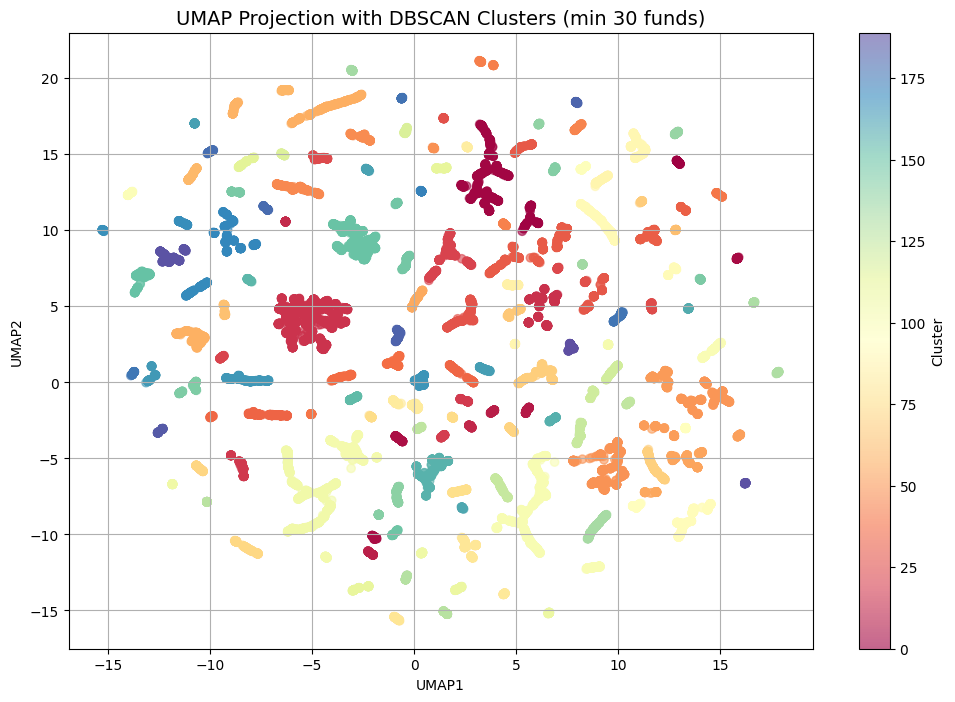

In [11]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df_umap_filtered['UMAP1'],
    df_umap_filtered['UMAP2'],
    c=df_umap_filtered['cluster'],
    cmap='Spectral',
    alpha=0.6
)

plt.title('UMAP Projection with DBSCAN Clusters (min 30 funds)', fontsize=14)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

## Reassigning Small Clusters via KMeans

Although DBSCAN is useful to detect organic clusters, it often leaves out small, sparse groups.

To ensure all funds are assigned to meaningful clusters:

1. We identify small clusters (with fewer than 100 funds).
2. We train a KMeans model on the larger groups.
3. Funds from small clusters are reassigned to the nearest KMeans centroid using `NearestCentroid`.

Finally, we merge the updated cluster assignments into the main dataset and export the result.

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_nearest_centroid.py:241: RuntimeWarning: invalid value encountered in divide
  np.sqrt(variance.sum(axis=0) / (n_samples - n_classes)), copy=False


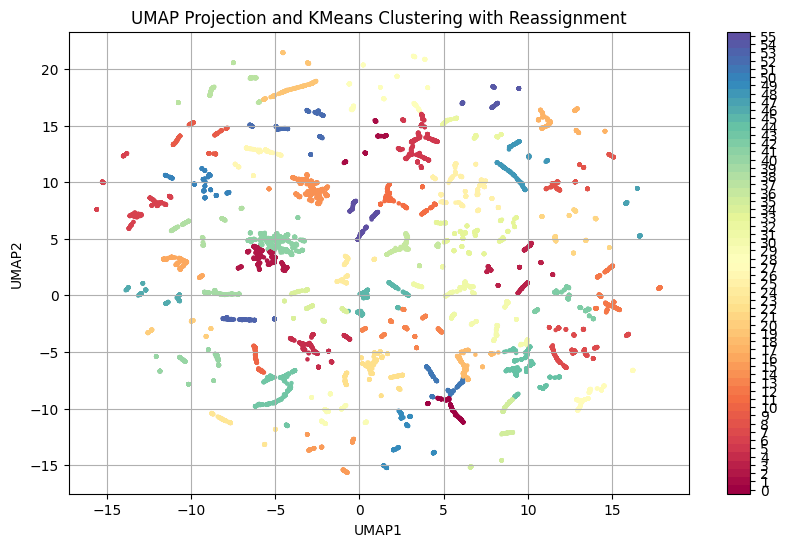

Cluster sizes after reassignment:
cluster
41    833
14    705
5     623
25    585
33    561
7     549
2     542
22    509
43    493
44    465
11    462
6     454
45    452
4     444
48    429
31    427
3     419
12    414
52    383
13    365
30    359
19    352
28    350
36    337
50    326
18    324
55    320
17    314
34    311
38    300
49    297
16    290
26    284
40    284
9     284
27    282
0     280
42    277
37    272
35    254
51    254
21    251
29    243
53    239
8     236
32    226
24    219
39    217
10    214
46    209
1     204
15    197
23    174
54    166
20    140
47    129
Name: count, dtype: int64
Clustered fund metadata preview:
           isin  allfunds_id  asset asset_type class_code  clean_share  \
0  LU0331286657       206399    4.0        RVG         C2        False   
1  LU0252964605        27584    4.0        RVG         D2         True   
2  LU1495983089        12993    4.0        RVG         I2        False   
3  LU0171290587         8123    4.0        

In [12]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid

small_clusters = df_umap['cluster'].value_counts()
small_clusters = small_clusters[small_clusters < 100].index
fondos_pequenos = df_umap[df_umap['cluster'].isin(small_clusters)].index

n_clusters = df_umap['cluster'].nunique() - len(small_clusters)

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(df_umap[['UMAP1', 'UMAP2']])
df_umap['cluster'] = clusters
centroids = kmeans.cluster_centers_
clf = NearestCentroid()
clf.fit(centroids, np.arange(n_clusters))

for fondo in fondos_pequenos:
    coords = df_umap.loc[fondo, ['UMAP1', 'UMAP2']].values.reshape(1, -1)
    new_cluster = clf.predict(coords)
    df_umap.at[fondo, 'cluster'] = new_cluster[0]

plt.figure(figsize=(10, 6))
plt.scatter(df_umap['UMAP1'], df_umap['UMAP2'], c=df_umap['cluster'], cmap='Spectral', s=5)
plt.colorbar(
    boundaries=np.arange(len(np.unique(df_umap['cluster']))+1)-0.5
).set_ticks(np.arange(len(np.unique(df_umap['cluster']))))
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection and KMeans Clustering with Reassignment')
plt.grid(True)
plt.show()

cluster_sizes = df_umap['cluster'].value_counts()
print("Cluster sizes after reassignment:")
print(cluster_sizes)

df_clusters = df_umap[['allfunds_id', 'cluster']]
maestro_filtrado = maestro_filtrado.merge(df_clusters, on='allfunds_id', how='left')

maestro_filtrado.to_csv('clusterized_funds.csv', index=False)
print("Clustered fund metadata preview:")
print(maestro_filtrado.head())